In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Identificador de petições iniciais

> Uma proposta de modelo de aprendizado supervisionado com a técnica de RandomForestClassifier


Trabalho desenvolvido no Programa de Residência em Tecnologia da Informação do
Instituto Metrópole Digital da Universidade Federal do Rio Grande do Norte como requisito de avaliação da disciplina IMD0390 - APRENDIZADO DE MÁQUINA
 
COMPONENTES: Matheus de Andrade, Ney Pimentel T. de Oliveira e Patrícia Sayonara G. de Araújo

PROFESSOR: Dr. Daniel Sabino Amorim de Araújo


# Imports de bibliotecas

In [ ]:
%pip install --user cleanlab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 8.0 MB/s 


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, balanced_accuracy_score, average_precision_score, accuracy_score, matthews_corrcoef, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib as jbl
from cleanlab.filter import find_label_issues
from cleanlab.dataset import health_summary
from pathlib import Path
from sklearn.model_selection import cross_val_predict
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sqlite3
from google.colab import output
import re

# Setup de diretório de trabalho

In [ ]:
#Setup
workdir = Path.cwd() / "drive/MyDrive/JFRN (1)/Classificador_Peticoes"
rf_dir = Path.cwd() / "drive/MyDrive/JFRN (1)/RandomForest-classification"

In [ ]:
data = workdir / 'data'
data_rf = rf_dir / 'data'
try:
  Path.mkdir(data_rf)
except FileExistsError as err:
  print(err, 'Path exists')

[Errno 17] File exists: '/content/drive/MyDrive/JFRN (1)/RandomForest-classification/data' Path exists


In [ ]:
models = workdir / 'Modelos'

In [ ]:
models_rf = rf_dir / 'Modelos'
try:
  Path.mkdir(models_rf)
except FileExistsError as err:
  print(err, 'Path exists')

[Errno 17] File exists: '/content/drive/MyDrive/JFRN (1)/RandomForest-classification/Modelos' Path exists


# ETL

## Dados versão 1

In [ ]:
textos = pd.read_csv(data/ 'transformacao.csv')

In [ ]:
peticoes = textos[textos.triagem_peticao != '2']

In [ ]:
peticoes.to_parquet(data_rf / 'textos.parquet')

In [ ]:
peticoes = pd.read_parquet(data_rf / 'textos.parquet')

In [ ]:
peticoes.columns.to_list()

['id_processo_judicial',
 'nr_processo_judicial',
 'nm_arquivo',
 'texto',
 'texto_limpo',
 'triagem_peticao']

## Dados de teste da versão 1

In [ ]:
# Colunas a serem usadas
columns = ['nr_processo_judicial','triagem_peticao','texto_limpo']

In [ ]:
# Dados de teste extraídos da base de dados de Jonathan Jalles
df_test = pd.read_csv(data / 'df_test.csv', sep=',')
df_manual = pd.read_csv(data / 'label_manual.csv', sep=',', header=None)
df_test['triagem_peticao'] = df_manual[1]
df_test = df_test[columns]

In [ ]:
df_test.shape

(50, 3)

## Nova ingestão de dados

Dados com características que não foram apreciadas em versão anterior do modelo e que trouxe problemas

In [ ]:
con = sqlite3.connect(data_rf / 'transformacao02_dados_novos.sqlite3')
peticoes_incr = pd.read_sql('select * from transformacao_02',con).drop('index',axis=1).copy()

In [ ]:
peticoes_incr = (peticoes_incr[['id_processo_judicial',
                'nr_processo_judicial', 
                'nm_arquivo',
                'texto']
               ])

In [ ]:
sample = peticoes_incr[peticoes_incr.nm_arquivo.str.contains(r"contrato*",case=False,regex=True)]

In [ ]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 55 to 66449
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id_processo_judicial  165 non-null    int64 
 1   nr_processo_judicial  165 non-null    object
 2   nm_arquivo            165 non-null    object
 3   texto                 165 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.4+ KB


In [ ]:
sample.reset_index(drop=True,inplace=True)

In [ ]:
# Rotulando amostra de dados
try:
  init = pd.read_csv(data_rf / 'labels.csv', sep=';', header=None).iloc[-1,0]
  count = pd.read_csv(data_rf / 'labels.csv', sep=';', header=None).shape[0]
except:
  init = 0
  count = 0
try:
  for i, texto in sample.texto[init:].items():
    print(count)
    try:
      print(texto)
    except:
      count += 1
      continue
    label: int = int(input())
    count += 1
    with open(data_rf / 'labels.csv', 'a') as f:
      f.write(f"{i};{label}\n")
    output.clear()
    if count >= 166:
      break
except KeyboardInterrupt as inter:
  print(inter.args[0])

In [ ]:
sample

,id_processo_judicial,nr_processo_judicial,nm_arquivo,texto
0,488534,0501788-54.2019.4.05.8405,petini_01 - CÍVEL - FEDERAL - AÇÃO RESCISÃO CO...,EXCELENTÍSSIMO SENHOR JUIZ TITULAR DA _ª VARA ...
1,491435,0514056-58.2019.4.05.8400,petini_595.INICIAL.RUY.PEREIRA.I.PARNAMIRIM.CO...,\n \nEXCELENTÍSSIMO SENHOR DOUTOR JUIZ DO...
2,491871,0514247-06.2019.4.05.8400,petini_571.INICIAL.RUY.PEREIRA.I.PARNAMIRIM.CO...,\n \nEXCELENTÍSSIMO SENHOR DOUTOR JUIZ DO...
3,491875,0514249-73.2019.4.05.8400,petini_575.INICIAL.RUY.PEREIRA.I.PARNAMIRIM.CO...,\n \nEXCELENTÍSSIMO SENHOR DOUTOR JUIZ DO...
4,492049,0514324-15.2019.4.05.8400,petini_668.INICIAL.RUY.PEREIRA.I.PARNAMIRIM.CO...,\n \nEXCELENTÍSSIMO SENHOR DOUTOR JUIZ DO...
...,...,...,...,...
160,623725,0507567-25.2021.4.05.8403,petini_2-Contrato de Honorários.pdf,CONTRA TO DE PRESTAÇÃO DE SERViÇOS ADVOCATíCIO...
161,623734,0507566-40.2021.4.05.8403,petini_2-Contrato de Honorarios.pdf,"CONTRA TO DE PRESTAÇÃO,DE SERViÇOS ADVOCATíCIO..."
162,628283,0508070-46.2021.4.05.8403,petini_2-Contrato de Honorario.pdf,CONTRA TO DE PRESTAÇÃO DE SERViÇOS ADVOCATíCIO...
163,628801,0500037-33.2022.4.05.8403,petini_2-Contrato de Honorários.pdf,CONTRA TO DE PRESTAÇÃO DE SERViÇOS ADVOCATíCIO...


## Limpando dados

In [ ]:
labels = pd.read_csv(data_rf / 'labels.csv', sep=';', names=['triagem_peticao'], index_col=0)

In [ ]:
incremento = sample.join(labels)

In [ ]:
incremento['texto'] = incremento['texto'].fillna('')

In [ ]:
#removendo \n, \r, pontuações e colocando o texto limpo em nova coluna:
incremento['texto_limpo'] = incremento.texto.apply(lambda x:re.sub(r"\W+"," ", x ).strip())

In [ ]:
incremento.drop('texto', axis=1, inplace=True)

In [ ]:
incremento.to_csv(data_rf / "incremento.csv", sep=';', index=False)

In [ ]:
peticoes.drop('texto', axis=1, inplace=True)

In [ ]:
processos = pd.concat([peticoes,incremento,df_test])

In [ ]:
processos

,id_processo_judicial,nr_processo_judicial,nm_arquivo,texto_limpo,triagem_peticao
0,211432.0,0500834-24.2013.4.05.8403,petini_02 - AMPARO SOCIAL - JOSEMAR DANTAS.rtf,Francisco das Chagas Rocha Advogado End Rua 24...,1
1,230497.0,0518741-21.2013.4.05.8400,petini_petição inicial de zélia.pdf,SORIA DONALDO CARVALHO RUA 15 DE NOVEMBRO 26 C...,1
2,236443.0,0521233-83.2013.4.05.8400,petini_AUXILIO DOENÇA - CONCESSÃO - QUALIDADE ...,PODER JUDICIÁRIO JUSTIÇA FEDERAL JUIZADOS ESPE...,1
3,347568.0,0502229-49.2016.4.05.8402,petini_Ação de Obrigação de Fazer com Danos Mo...,EXCELENTÍSSIMO A SENHOR A DOUTOR A JUÍZ A FEDE...,1
4,437826.0,0502637-66.2018.4.05.8403,doc_CÁLCULO INSS - INDICE DE CORREÇÃO DE INPC+...,Relátorio Planilha SISTEMA DE CÁLCULO e Pcalc ...,0
...,...,...,...,...,...
45,NaN,0500528-76.2018.4.05.8404,NaN,EXMO Marcos Inácio Advocacia I S S JCL 1 EXMO ...,1
46,NaN,0514526-94.2016.4.05.8400,NaN,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DE U...,1
47,NaN,0507456-23.2016.4.05.8401,NaN,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DO J...,1
48,NaN,0522016-02.2018.4.05.8400,NaN,1 Rua Dr Carlos Matheus 510 A Monte Castelo Pa...,1


In [ ]:
processos = processos[processos.triagem_peticao != 2].copy()

In [ ]:
processos.triagem_peticao.value_counts(normalize=True)

1    0.55364
0    0.44636
Name: triagem_peticao, dtype: float64

In [ ]:
processos.drop_duplicates(subset=['texto_limpo'],inplace=True)

In [ ]:
processos.reset_index(drop=True,inplace=True)

In [ ]:
# Classificador 1
#dividindo primeiro em treino e validação
df_train, df_valid = train_test_split(processos, test_size=0.2, stratify=processos.triagem_peticao, random_state=314)

#dividindo o set de validação em 2, para coletar o set de teste
df_valid, df_test = train_test_split(df_valid, test_size=0.5, stratify=df_valid.triagem_peticao, random_state=314)

In [ ]:
#escrevendo dados final de treino
df_train.to_parquet(data_rf / 'train.parquet')
df_valid.to_parquet(data_rf / 'valid.parquet')
df_test.to_parquet(data_rf / 'test.parquet')

# Treinando Random Forest

## Criar features

In [ ]:
from nltk.corpus import stopwords
import nltk
from string import punctuation
# Criando set com stopwwords em português e pontuações para serem removidas dos textos
nltk.download('stopwords')
stopwords = set(stopwords.words('portuguese') + list(punctuation))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_train = pd.read_parquet(data_rf / 'train.parquet')
df_test = pd.read_parquet(data_rf / 'test.parquet')
df_valid = pd.read_parquet(data_rf / 'valid.parquet')

In [ ]:
df_train.shape

(814, 5)

In [ ]:
df_valid.shape

(102, 5)

In [ ]:
df_test.shape

(102, 5)

In [ ]:
# Filtrando somente colunas de interesse
train = df_train.texto_limpo
valid = df_valid.texto_limpo
test = df_test.texto_limpo

In [ ]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,1), strip_accents='unicode', lowercase=True, stop_words=stopwords)

In [ ]:
%%time
# Vetorizando textos para alimentar os modelos
bow_train = tfidf_vec.fit_transform(train)
bow_valid = tfidf_vec.transform(valid)
bow_test = tfidf_vec.transform(test)

CPU times: user 2.71 s, sys: 18.1 ms, total: 2.73 s
Wall time: 2.74 s


In [ ]:
bow_train.shape, bow_valid.shape, bow_test.shape

((814, 38747), (102, 38747), (102, 38747))

In [ ]:
# Criando séries com os rótulos
y_train = df_train.triagem_peticao
y_valid = df_valid.triagem_peticao
y_teste = df_test.triagem_peticao

## Usando cleanlab para verificação

In [ ]:
rf_model = RandomForestClassifier(random_state=314, n_jobs=14)

In [ ]:
X = pd.concat([train,valid,test])

In [ ]:
# Vetorizando textos para alimentar os modelos
x_bow = tfidf_vec.transform(X)

In [ ]:
x_bow.shape

(1018, 38747)

In [ ]:
y = pd.concat([y_train,y_valid,y_teste])

In [ ]:
y.shape

(1018,)

In [ ]:
num_crossval_folds = 3
pred_probs = cross_val_predict(
    rf_model,
    x_bow,
    y,
    cv=num_crossval_folds,
    method="predict_proba"
)

In [ ]:
ranked_label_issues = find_label_issues(
    labels=y,
    pred_probs=pred_probs,
    return_indices_ranked_by="self_confidence"
)

In [ ]:
import json

with open(data_rf / 'ranked_label_issues.txt', 'w') as filehandle:
    json.dump(ranked_label_issues.tolist(), filehandle)

In [ ]:
print(
    f"cleanlab found {len(ranked_label_issues)} potential label errors.\n"
    f"Here are indices of the top 50 most likely errors: \n {ranked_label_issues[:50]}"
)

cleanlab found 6 potential label errors.
Here are indices of the top 50 most likely errors: 
 [266 639 609 633 653 745]


Analisando textos e corrigindo possíveis erros de rótulos

In [ ]:
df_train[df_train.nr_processo_judicial == "0500574-70.2015.4.05.8404"]

,id_processo_judicial,nr_processo_judicial,nm_arquivo,texto_limpo,triagem_peticao
97,284448.0,0500574-70.2015.4.05.8404,petini_petini_peticao_Acao Previdenciaria - LO...,PROCURAÇÃO EXCELENTÍSSIMO SENHOR DOUTOR JUIZ D...,0


In [ ]:
df_train.loc[97,'triagem_peticao'] = 1

In [ ]:
df_train[df_train.nr_processo_judicial == "0500574-70.2015.4.05.8404"]

,id_processo_judicial,nr_processo_judicial,nm_arquivo,texto_limpo,triagem_peticao
97,284448.0,0500574-70.2015.4.05.8404,petini_petini_peticao_Acao Previdenciaria - LO...,PROCURAÇÃO EXCELENTÍSSIMO SENHOR DOUTOR JUIZ D...,1


In [ ]:
df_train[df_train.nr_processo_judicial == "0500551-33.2015.4.05.8402"]

,id_processo_judicial,nr_processo_judicial,nm_arquivo,texto_limpo,triagem_peticao
259,285901.0,0500551-33.2015.4.05.8402,petini_petição inicial.pdf,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ DO JUIZADO E...,0


In [ ]:
df_train.loc[259,'triagem_peticao'] = 1

In [ ]:
df_train[df_train.nr_processo_judicial == "0500551-33.2015.4.05.8402"]

,id_processo_judicial,nr_processo_judicial,nm_arquivo,texto_limpo,triagem_peticao
259,285901.0,0500551-33.2015.4.05.8402,petini_petição inicial.pdf,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ DO JUIZADO E...,1


In [ ]:
X[266]

In [ ]:
y[266]

0

In [ ]:
X[639]

In [ ]:
y[639]

1

In [ ]:
X[609]

In [ ]:
y[609]

1

In [ ]:
X[633]

In [ ]:
y[633]

1

In [ ]:
X[653]

In [ ]:
y[653]

1

In [ ]:
X[745]

In [ ]:
y[745]

1

In [ ]:
df_train.to_parquet(data_rf / 'train.parquet')

## Treinamento RandomForestClassifier
Hyper Parameter Tuning ~ Random Forest

n_estimators : Number of Trees in Random Forest

max_features : Max Number of Features to be considered at each split

max_depth : Max Depth of each estimator

min_sample_split : Minimum Samples required for Valid Split

min_samples_leaf : Minimum samples required at each leaf node

criterion: The function to measure the quality of a split.

### Carregando dados e pré-processamento

In [ ]:
df_train = pd.read_parquet(data_rf / 'train.parquet')
df_test = pd.read_parquet(data_rf / 'test.parquet')
df_valid = pd.read_parquet(data_rf / 'valid.parquet')

In [ ]:
df_train.shape, df_valid.shape, df_test.shape

((814, 5), (102, 5), (102, 5))

In [ ]:
# Filtrando somente colunas de interesse
train = df_train.texto_limpo
valid = df_valid.texto_limpo
test = df_test.texto_limpo

In [ ]:
from nltk.corpus import stopwords
import nltk
from string import punctuation
# Criando set com stopwwords em português e pontuações para serem removidas dos textos
nltk.download('stopwords')
stopwords = set(stopwords.words('portuguese') + list(punctuation))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,1), strip_accents='unicode', lowercase=True, stop_words=stopwords)

In [ ]:
%%time
# Vetorizando textos para alimentar os modelos
bow_train = tfidf_vec.fit_transform(train)
bow_valid = tfidf_vec.transform(valid)
bow_test = tfidf_vec.transform(test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  % sorted(inconsistent)


CPU times: user 3.49 s, sys: 37.5 ms, total: 3.52 s
Wall time: 3.54 s


In [ ]:
# Salvando vetorizador
path = Path('/content/drive/MyDrive/Residência JFRN IMD/Matérias/Machine Learning/RandomForest-classification')
jbl.dump(tfidf_vec, path / 'Modelos/tfidf_vectorizer.pkl.z')

['/content/drive/MyDrive/Residência JFRN IMD/Matérias/Machine Learning/RandomForest-classification/Modelos/tfidf_vectorizer.pkl.z']

In [ ]:
bow_train.shape, bow_valid.shape, bow_test.shape

((814, 38747), (102, 38747), (102, 38747))

In [ ]:
# Criando séries com os rótulos
y_train = df_train.triagem_peticao
y_valid = df_valid.triagem_peticao
y_teste = df_test.triagem_peticao

In [ ]:
%%time
# Salvando matriz 
path = Path('/content/drive/MyDrive/Residência JFRN IMD/Matérias/Machine Learning/RandomForest-classification')
scipy.sparse.save_npz(path / "data/train_ngram1.npz", bow_train)
scipy.sparse.save_npz(path / "data/valid_ngram1.npz", bow_valid)

CPU times: user 451 ms, sys: 10.7 ms, total: 461 ms
Wall time: 481 ms


In [ ]:
# Salvando rótulos
path = Path('/content/drive/MyDrive/Residência JFRN IMD/Matérias/Machine Learning/RandomForest-classification')
y_train.to_csv(path / "data/y_train.csv")
y_valid.to_csv(path / "data/y_valid.csv")

### Tuning modelo

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 40)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# The function to measure the quality of a split. 
criterion = ['gini', 'entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'criterion' : criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
print(random_grid)

{'n_estimators': [10, 61, 112, 163, 214, 265, 316, 367, 418, 469, 520, 571, 622, 673, 724, 775, 826, 877, 928, 979, 1030, 1081, 1132, 1183, 1234, 1285, 1336, 1387, 1438, 1489, 1540, 1591, 1642, 1693, 1744, 1795, 1846, 1897, 1948, 2000], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [ ]:
%%time
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=314, n_jobs=-1)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=314, n_jobs = -1)
# Fit the random search model
rf_random.fit(bow_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
rf_random.best_params_

{'n_estimators': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 100,
 'criterion': 'entropy'}

In [ ]:
rf_random.best_score_, rf_random.best_estimator_

(0.9717368497214384,
 RandomForestClassifier(criterion='entropy', max_depth=100, max_features='sqrt',
                        min_samples_leaf=4, n_estimators=10, n_jobs=-1,
                        random_state=314))

In [ ]:
with open(data_rf / 'best_params.json', 'w') as filehandle:
    json.dump(rf_random.best_params_, filehandle)

In [ ]:
with open(data_rf / 'best_params.json', 'r') as reader:
  best_params = reader.read()

In [ ]:
best_params

'{"n_estimators": 10, "min_samples_split": 2, "min_samples_leaf": 4, "max_features": "sqrt", "max_depth": 100, "criterion": "entropy"}'

### Treinando com os parâmetros encontrados

In [ ]:
rf_model = RandomForestClassifier(n_estimators=10, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=100, random_state=314, criterion='entropy', n_jobs=-1)

In [ ]:
rf_model.fit(bow_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=100, max_features='sqrt',
                       min_samples_leaf=4, n_estimators=10, n_jobs=-1,
                       random_state=314)

In [ ]:
print(f'Acurácia de treinamento: {rf_model.score(bow_train,y_train)}')

Acurácia de treinamento: 0.9889434889434889


In [ ]:
path = Path('/content/drive/MyDrive/Residência JFRN IMD/Matérias/Machine Learning/RandomForest-classification/Modelos')
jbl.dump(rf_model, path / "random_forest_20221117.pkl.z")

['/content/drive/MyDrive/Residência JFRN IMD/Matérias/Machine Learning/RandomForest-classification/Modelos/random_forest_20221117.pkl.z']

### Avaliando modelo

In [ ]:
# Gerando predições
y_pred = rf_model.predict(bow_valid)

In [ ]:
# Métricas de avaliação
f1 = f1_score(y_valid, y_pred, average='micro')
f1_w = f1_score(y_valid, y_pred, average='weighted')
mcc = matthews_corrcoef(y_valid, y_pred)
kappa = cohen_kappa_score(y_valid, y_pred)
bacc = balanced_accuracy_score(y_valid, y_pred)
acc = accuracy_score(y_valid, y_pred)

In [ ]:
f' F1-micro: {f1:.4f} - F1-Weighted: {f1_w:.4f} - MCC: {mcc:.4f} -Kappa: {kappa:.4f} - BACC: {bacc:.4f} - ACC: {acc:.4f} \n'

' F1-micro: 0.9902 - F1-Weighted: 0.9902 - MCC: 0.9802 -Kappa: 0.9800 - BACC: 0.9886 - ACC: 0.9902 \n'

In [ ]:
# Relatório de classificação
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.98      1.00      0.99        58

    accuracy                           0.99       102
   macro avg       0.99      0.99      0.99       102
weighted avg       0.99      0.99      0.99       102



In [ ]:
# Matriz de confusão
print(confusion_matrix(y_valid, y_pred))

[[43  1]
 [ 0 58]]


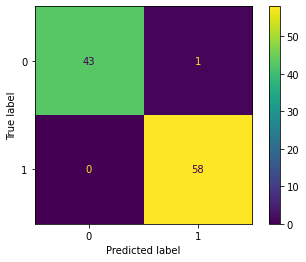

In [ ]:
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
df_valid['pred'] = y_pred

In [ ]:
df_valid[df_valid.triagem_peticao != df_valid.pred]

,id_processo_judicial,nr_processo_judicial,nm_arquivo,texto_limpo,triagem_peticao,pred
19,257268.0,0500095-71.2014.4.05.9840,petição_AI GDACE (JFRN) Marcos Antônio Silva.doc,EXMO SR DR JUIZ PRESIDENTE DO COLÉGIO RECURSAL...,0,1


In [ ]:
df_valid.loc[19,'texto_limpo']

Análise de features da floresta

In [ ]:
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

In [ ]:
feature_names = tfidf_vec.get_feature_names_out()

In [ ]:
feature_importances = pd.DataFrame({'Importância': rf_model.feature_importances_, 'Desvio': std}, index=feature_names ).sort_values('Importância', ascending=False)

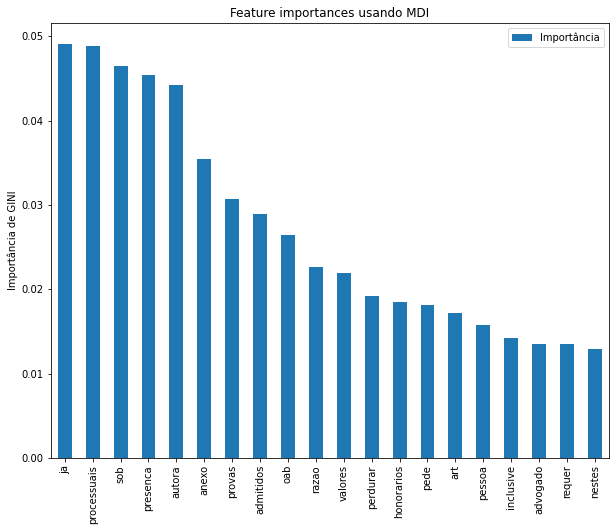

In [ ]:
features_top20 = feature_importances[:20]
features_top20.plot.bar(y='Importância', title="Feature importances usando MDI", ylabel="Importância de GINI", figsize=(10,8))

Verifica-se que há espaço para melhoras do modelos de linguagem, onde poderiam ser acrescidos termos que não trazem muito valor para o escopo do trabalho como algumas conjunções.

### Avaliando com dados de teste

In [ ]:
rf_model = jbl.load(models_rf / "random_forest_20221117.pkl.z")

In [ ]:
print(f'Acurácia de teste: {rf_model.score(bow_test,y_teste)}')

Acurácia de teste: 0.9901960784313726


In [ ]:
y_pred = rf_model.predict(bow_test)

In [ ]:
# Relatório de classificação
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       1.00      0.98      0.99        57

    accuracy                           0.99       102
   macro avg       0.99      0.99      0.99       102
weighted avg       0.99      0.99      0.99       102



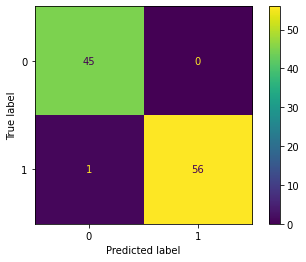

In [ ]:
cm = confusion_matrix(y_teste, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Visualizando árvore de decisão

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, balanced_accuracy_score, average_precision_score, accuracy_score, matthews_corrcoef, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib as jbl
from pathlib import Path
from sklearn.model_selection import cross_val_predict
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sqlite3
from google.colab import output

In [ ]:
# Carregando o modelo
path = Path('/content/drive/MyDrive/Residência JFRN IMD/Matérias/Machine Learning/RandomForest-classification/Modelos')
model = jbl.load(path / 'random_forest_20221117.pkl.z')

In [ ]:
# Salvando vetorizador
path = Path('/content/drive/MyDrive/Residência JFRN IMD/Matérias/Machine Learning/RandomForest-classification')
tfidf_vec = jbl.load(path / 'Modelos/tfidf_vectorizer.pkl.z')

In [ ]:
path = Path('/content/drive/MyDrive/Residência JFRN IMD/Matérias/Machine Learning/RandomForest-classification/data')
df_train = pd.read_parquet(path / "train.parquet")
df_valid = pd.read_parquet(path / "valid.parquet")
df_test = pd.read_parquet(path / "test.parquet")
df = pd.concat([df_train, df_valid, df_test]).reset_index(drop=True)

In [ ]:
model.feature_importances_

array([0.00021353, 0.00101525, 0.00358183, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
model.n_features_in_

38747

In [ ]:
len(tfidf_vec.get_feature_names_out())

38747

In [ ]:
df.triagem_peticao.unique()

array([0, 1])

In [ ]:
for i in range(10):
  from sklearn.tree import export_graphviz
  estimator = model.estimators_[i]
  export_graphviz(estimator, out_file=f'tree{i}.dot',
                  feature_names = tfidf_vec.get_feature_names_out(),
                  class_names = ['0','1'],
                  rounded = True, proportion = False, 
                  precision = 2, filled = True)

  from subprocess import call
  path = Path('/content/drive/MyDrive/Residência JFRN IMD/Matérias/Machine Learning/RandomForest-classification/Imagens')
  call(['dot', '-Tpng', f'tree{i}.dot', '-o', path / f'tree{i}.png', '-Gdpi=600'])

  #from IPython.display import Image
  #Image(filename = 'tree0.png')